# L20_GW_classification

All experiments have selection effects. Some sources are easier to detect than others which distorts the population of sources we observe (this crucial in astronomy! Surveys are typically flux limited). In order to decided if a feature in the observed population of objects is telling us something new about reality, we need to understand and model our selection effects (for instance: it would be wrong to say that all stars are close by just because we can't observe those that are very far!). 
 
**The goal here is to machine-learn the LIGO detectability: can we *predict* if a gravitational-wave source will be detected?**  

[This dataset](https://github.com/dgerosa/pdetclassifier/releases/download/v0.2/sample_2e7_design_precessing_higherordermodes_3detectors.h5) contains simulated gravitational-wave signals from merging black holes (careful the file size is >1 GB). You can read this data format with `h5py`.

In particular, each source has the following features:
- `mtot`: the total mass of the binary
- `q`: the mass ratio
- `chi1x`, `chi1y`, `chi1z`, `chi2x`, `chi2y`, `chi2z`: the components of the black-hole spins in a suitable reference frame.
- `ra`, `dec`: the location of the source in the sky
- `iota`: the inclination of the orbital plane'
- `psi`: the polarization angle (gravitational waves have two polarization states much like light)
- `z`: the redshift

The detectability is defined using the `snr` (signal-to-noise ratio) computed with a state-of-the-art model of the LIGO/Virgo detector network. Some (many?) of you will have studied this in Sesana's gravitational-wave course; [see here](https://arxiv.org/abs/1908.11170) for a nice write-up. All you need to know now is that we threshold the `snr` values and assume that LIGO will (not) see a source if `snr`>12 (`snr`<12). The resulting 0-1 labels are reported in the `det` attribute in the dataset.

Today's task is to train a classifier (you decide which one!) and separate sources that are detectables from those that aren't. 

Be creative! This is a challenge! Let's see who gets the  higher completeness and/or the smaller contamination (on a validation set, of course! Careful with overfitting here!).

*Tips*:
- You can downsample the data for debugging purposes
- You can also use only some of the features. By experience, the most important ones are those involving masses and redshift.

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = h5py.File('sample_2e7_design_precessing_higherordermodes_3detectors.h5', 'r')

In [3]:
print(data['z'].shape)

(20000000,)


Here I'm downsampling the dataset.

In [4]:
#taking only the first 10000 samples

z = data['z'][:10000]
mtot = data['mtot'][:10000]
q = data['q'][:10000]
det = data['det'][:10000]
iota = data['iota'][:10000]
psi = data['psi'][:10000]
chi1x = data['chi1x'][:10000]
chi1y = data['chi1y'][:10000]
chi1z = data['chi1z'][:10000]
chi2x = data['chi2x'][:10000]
chi2y = data['chi2y'][:10000]
chi2z = data['chi2z'][:10000]
ra = data['ra'][:10000]
dec = data['dec'][:10000]
snr = data['snr'][:10000]

Let's show some histograms for each feature to see which of them seem more important to discern detectable and undetectable sources.

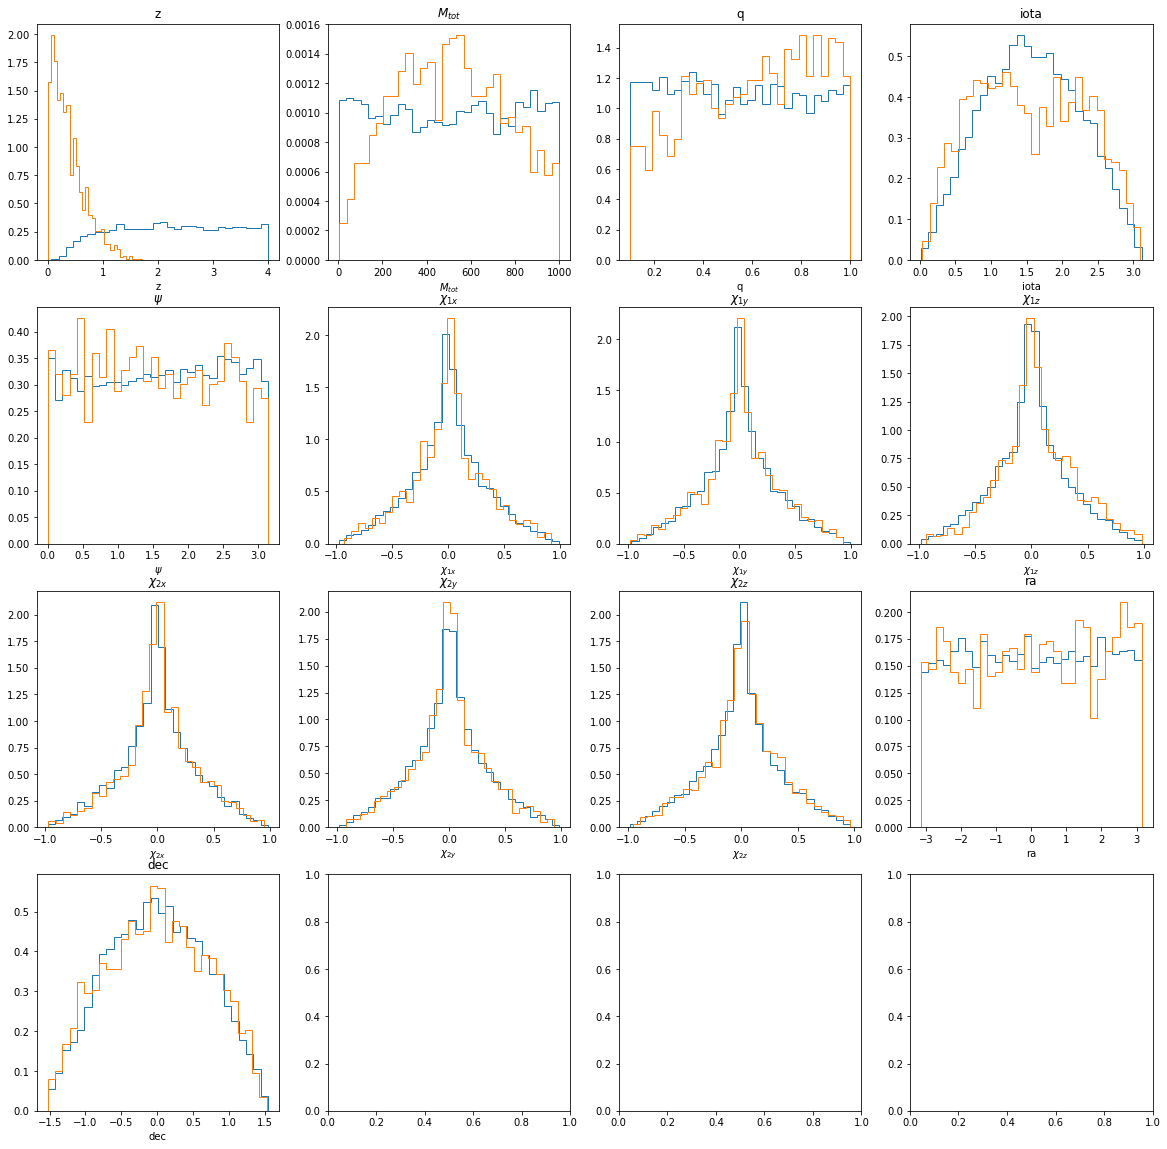

In [5]:
fig, ax = plt.subplots(4,4, figsize=(20,20))
ax=ax.reshape(16)

feature=np.array([z, mtot, q, iota, psi, chi1x, chi1y, chi1z, chi2x, chi2y, chi2z, ra, dec])
feature_name = ['z', '$M_{tot}$', 'q', 'iota', '$\psi$', '$\chi_{1x}$', '$\chi_{1y}$', '$\chi_{1z}$', '$\chi_{2x}$', '$\chi_{2y}$', '$\chi_{2z}$', 'ra', 'dec']
for i,j, k in zip(ax, feature, feature_name):
    i.hist(j[det==0], histtype='step', density=True, bins=30)
    i.hist(j[det==1], histtype='step', density=True, bins=30)
    i.set_title(k)
    i.set_xlabel(k)

The most important components where detectable and undetectable sources behaves differently are definitely the first 4 or 5, they're the most important for classification.
For this reason in the following cells I apply different classifiers to two sets of data: one composed by the first 4 original features of the dataset and the other composed by the first 3 PCA decomposed features.

Of course I need to divide the dataset into training and test set.

In [6]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(feature.T, det, test_size=0.25, random_state=12)

In [7]:
from sklearn.decomposition import PCA


#PCA reduction to 3 components
pca=PCA(n_components=12)
pca.fit(feature.T)
var = pca.explained_variance_ratio_ #variance explained
print('The total variance esplained by the first 3 components is: ', np.sum(var))

eigenval = pca.transform(feature.T) #new PCA reducted features
print(eigenval.shape)

#dividing the PCA dataset into train and test sets exactly as before
x_train_pca, x_test_pca, y_train_pca, y_test_pca = train_test_split(eigenval, det, test_size=0.25, random_state=12)

print(np.where(y_test!=y_test_pca)) #checking the test_pca samples are the same as the test samples above 

The total variance esplained by the first 3 components is:  0.9999991762315871
(10000, 12)
(array([], dtype=int64),)


With just 3 components we can account for 99.99% of the total variance!

In the following cell I implement a function similar to the one used in the previous exercise (L19). This function can be used with different classification algorithms and it returns some of the most important quantities as completeness, contamination, true positive rate, false positive rate, accuracy.

In [8]:
from astroML.utils import split_samples
from sklearn.metrics import roc_curve
from astroML.utils import completeness_contamination
from sklearn.metrics import accuracy_score

def useful_function(x_train, x_test, y_train, y_test, n, *args):#n = number of features to consider, args=Classifier+hyperpar
    
    clas = args[0][0](**args[0][1])
    clas.fit(x_train[:,:n], y_train)
    y_pred = clas.predict(x_test[:,:n]) #predicted labels for test set
    y_prob = clas.predict_proba(x_test[:,:n])[:,1] #predicted probability for each test sample of being detected
    
    fpr, tpr, thresh = roc_curve(y_test, y_prob) #roc curve

    completeness, contamination = completeness_contamination(y_pred, y_test) #completeness contamination
    accuracy = accuracy_score(y_test, y_pred) #accuracy
    
    fpr = np.concatenate([[0], fpr])
    tpr = np.concatenate([[0], tpr])
    
    return y_pred, y_prob, completeness, contamination, fpr, tpr, accuracy


## Logistic regression

Let's try with Logistic regression first. Here I have two results: one for the algorithm applied to the first four components of the original data, and the other applied on the first 3 components of PCA-modified data. 

In [9]:
from sklearn.linear_model import LogisticRegression

y_pred_lr, y_prob_lr, compl_lr, cont_lr, fpr_lr, tpr_lr, acc_lr = useful_function(x_train, x_test, 
                                                                                          y_train, y_test, 4, 
                                                                                          (LogisticRegression, dict(class_weight='balanced')))
y_pred_lr_pca, y_prob_lr_pca, compl_lr_pca, cont_lr_pca, fpr_lr_pca, tpr_lr_pca, acc_lr_pca = useful_function(x_train_pca, 
                                                                                                                  x_test_pca, 
                                                                                                                  y_train_pca, 
                                                                                                                  y_test_pca, 3,
                                                                                                                  (LogisticRegression, dict(class_weight='balanced')))



## Decision Tree

In this algorithm we need to tune a hyperparameter: the depth of the tree. Here I used GridSearchCV to get the optimal value both in the case where the classifier is applied to a section of the original data, and in the case where it is applied to the first 3 components or PCA reducted data.

In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

#optimal depth for original train data with 4 dimensions
clf = DecisionTreeClassifier()
drange = np.arange(1,21)

grid = GridSearchCV(clf, param_grid={'max_depth': drange}, cv=8)
grid.fit(x_train[:,:4], y_train)

best = grid.best_params_['max_depth']
print("best parameter choice:", best)

#optimal depth for PCA data with 3 dimensions
grid.fit(x_train_pca[:,:3], y_train_pca)

best_pca = grid.best_params_['max_depth']
print("best parameter choice:", best_pca)


best parameter choice: 7
best parameter choice: 4


I use these values inside the function!

In [11]:
from sklearn.tree import DecisionTreeClassifier

y_pred_dt, y_prob_dt, compl_dt, cont_dt, fpr_dt, tpr_dt, acc_dt = useful_function(x_train, x_test, y_train, y_test, 4, (DecisionTreeClassifier, dict(max_depth=best, criterion='entropy')))

y_pred_dt_pca, y_prob_dt_pca, compl_dt_pca, cont_dt_pca, fpr_dt_pca, tpr_dt_pca, acc_dt_pca = useful_function(x_train_pca, x_test_pca, y_train_pca, y_test_pca, 3, (DecisionTreeClassifier, dict(max_depth=best_pca, criterion='entropy')))


## Random Forest

Let's try also with Random Forest! In this case the number of hyperparameters to tune is 2: the number of estimators to run and the depth of the trees. Let's suppose that I want to find them in order to maximise the accuracy: what I can do is build a grid of values with both hyperparameters and evaluate the accuracy I get with a Random Forest classifier with those parameters. Below I implemented the code and I show that maximising the accuracy on the test set is the same as minimizing the RMS error on the test set, because of course the accuracy is defined as: 

$$\mathrm{acc} = \frac{\mathrm{true \ negative}+ \mathrm{true \ positive}}{\mathrm{N \ samples}}$$

and the test RMS is:

$$\epsilon_{\mathrm{test}} = \sqrt{\frac{1}{N_{\mathrm{test}}} \sum_{i}{(y_i - \hat{y}_{i})^2}}$$

Therefore when we have the highest number of correct classifications the accuracy is maximised and the test RMS error is minimised.

In [12]:
from sklearn.ensemble import RandomForestClassifier

n_range=np.arange(1,20) #possible values for the number of estimators
m_depth=np.arange(1,13) #possible values for the depth of trees

xx, yy = np.meshgrid(n_range, m_depth)
acc = np.zeros(xx.shape) #acc is a matrix[m_depth, n_range]
test_rms = np.zeros(xx.shape) #RMS error test

for i in range(len(n_range)):
    for j in range(len(m_depth)):
        clf = RandomForestClassifier(n_estimators=n_range[i], max_depth=m_depth[j], random_state=0)
        clf.fit(x_train[:,:4], y_train)
        y_pred = clf.predict(x_test[:,:4])
        acc[j,i] = accuracy_score(y_test, y_pred)
        test_rms[j,i] = np.sqrt(1/len(y_test)*np.sum((y_test-y_pred)**2))

The optimal number for the depth is:  10 
The optimal number of estimators is:  12


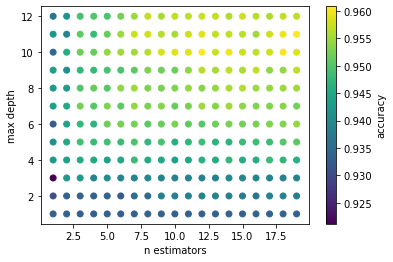

In [13]:
plt.scatter(xx,yy, c=acc)
cbar = plt.colorbar()
cbar.set_label('accuracy')
plt.xlabel('n estimators')
plt.ylabel('max depth')
print('The optimal number for the depth is: ', np.where(acc==np.max(acc))[0][0]+1, '\nThe optimal number of estimators is: ', np.where(acc==np.max(acc))[1][0]+1)

The optimal number for the depth is:  10 
The optimal number of estimators is:  12


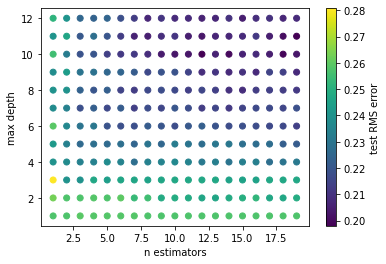

In [14]:
plt.scatter(xx,yy, c=test_rms)
cbar = plt.colorbar()
cbar.set_label('test RMS error')
plt.xlabel('n estimators')
plt.ylabel('max depth')
print('The optimal number for the depth is: ', np.where(test_rms==np.min(test_rms))[0][0]+1, '\nThe optimal number of estimators is: ', np.where(acc==np.max(acc))[1][0]+1)

And then let's use these numbers inside the classifier.

In [15]:
#for original data with 4 components
clas = RandomForestClassifier(n_estimators=12, max_depth=10, random_state=0)
clas.fit(x_train[:,:4], y_train)
y_pred = clas.predict(x_test[:,:4]) #predicted labels for the test set
y_prob = clas.predict_proba(x_test[:,:4])[:,1] #predicted probability for each test sample of being detected
    
fpr_rf, tpr_rf, thresh_rf = roc_curve(y_test, y_prob) #roc curve

compl_rf, cont_rf = completeness_contamination(y_pred, y_test) #completeness contamination
acc_rf = accuracy_score(y_test, y_pred)
    
fpr_rf = np.concatenate([[0], fpr_rf])
tpr_rf = np.concatenate([[0], tpr_rf])


#for PCA data
clas = RandomForestClassifier(n_estimators=12, max_depth=11, random_state=0)
clas.fit(x_train_pca[:,:3], y_train_pca)
y_pred = clas.predict(x_test_pca[:,:3]) #predicted labels for the test set 
y_prob = clas.predict_proba(x_test_pca[:,:3])[:,1] #predicted probability for each test sample of being detected
    
fpr_rf_pca, tpr_rf_pca, thresh_rf_pca = roc_curve(y_test_pca, y_prob) #roc curve

compl_rf_pca, cont_rf_pca = completeness_contamination(y_pred, y_test_pca) #completeness contamination
acc_rf_pca = accuracy_score(y_test_pca, y_pred)
    
fpr_rf_pca = np.concatenate([[0], fpr_rf_pca])
tpr_rf_pca = np.concatenate([[0], tpr_rf_pca])


### Considerations

Here I compare results from the three discriminative classifiers used above.


First, let's plot the ROC curves.

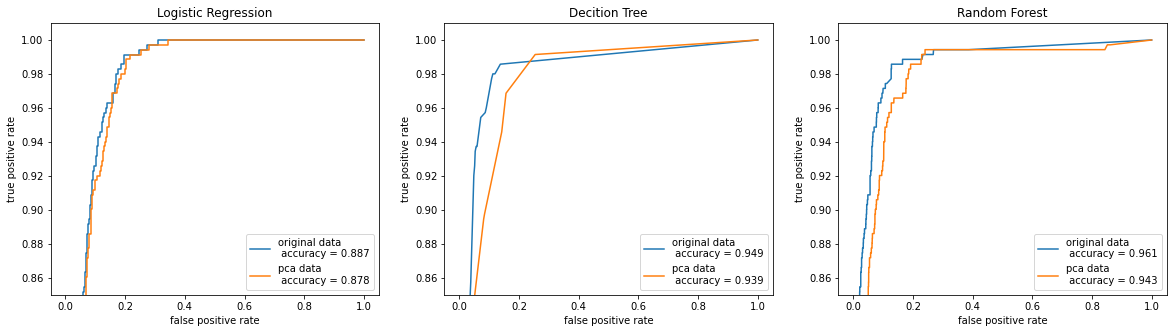

In [16]:
fig, ax = plt.subplots(1,3, figsize=(20, 5))
ax=ax.reshape(3)

#for i in range(len(fpr_lr)):
ax[0].plot(fpr_lr, tpr_lr, label='original data \n accuracy = %.3f' %acc_lr)
ax[0].set_title('Logistic Regression')
ax[0].plot(fpr_lr_pca, tpr_lr_pca, label='pca data \n accuracy = %.3f' %acc_lr_pca)

ax[1].plot(fpr_dt, tpr_dt, label='original data \n accuracy = %.3f' %acc_dt)
ax[1].set_title('Decition Tree')
ax[1].plot(fpr_dt_pca, tpr_dt_pca, label='pca data \n accuracy = %.3f' %acc_dt_pca)

ax[2].plot(fpr_rf, tpr_rf, label='original data \n accuracy = %.3f' %acc_rf)
ax[2].set_title('Random Forest')
ax[2].plot(fpr_rf_pca, tpr_rf_pca, label='pca data \n accuracy = %.3f' %acc_rf_pca)


for j in ax[:3]:   
    j.set_ylim(0.85, 1.01) 
    j.legend()
    j.set_ylabel('true positive rate')
    j.set_xlabel('false positive rate')


In all the three cases the classifiers seem to perform really well on the first 4 components of the original dataset, while on the PCA reducted dataset the accuracy is lower. This could be due to the fact that the first 3 PCA components are accounting for a lot of noise with respect to the original values. 
The best accuracy is reached through Random Forest with a value of 96%, and of course the area of the ROC is maximised in this case.

However, we could also want to have knowledge on the misclassified events, in this case it could be useful to look at completeness and contamination.

Text(1.84, 0.18544668587896251, '0.135')

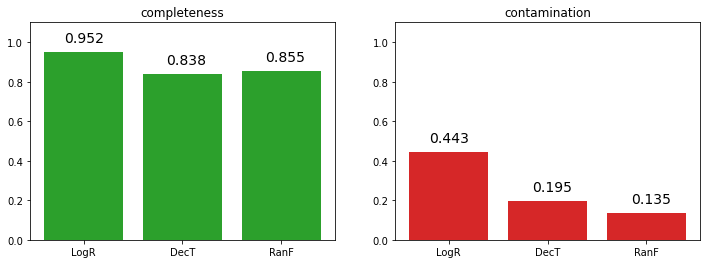

In [17]:
#Completeness and contamination for original data
fig, ax = plt.subplots(1,2, figsize=(12,4))

alg = ('LogR', 'DecT', 'RanF')
compl = [compl_lr, compl_dt, compl_rf]
cont = [cont_lr, cont_dt, cont_rf]

x_pos = np.arange(len(compl))
ax[0].bar(x_pos,compl, color='tab:green')
ax[1].bar(x_pos, cont, color='tab:red')

ax[0].set_title('completeness')
ax[1].set_title('contamination')

for i in range(len(ax)):
    ax[i].set_xticks(x_pos)
    ax[i].set_xticklabels(alg)
    ax[i].set_ylim(0, 1.1)

ax[0].text( -0.2, compl[0]+0.05, "%.3f" %compl[0], fontsize=14)
ax[0].text(1-0.16, compl[1]+0.05, "%.3f" %compl[1], fontsize=14)
ax[0].text(2-0.16, compl[2]+0.05, "%.3f" %compl[2], fontsize=14)

ax[1].text( -0.2, cont[0]+0.05, "%.3f" %cont[0], fontsize=14)
ax[1].text(1-0.16, cont[1]+0.05, "%.3f" %cont[1], fontsize=14)
ax[1].text(2-0.16, cont[2]+0.05, "%.3f" %cont[2], fontsize=14)

Text(1.84, 0.22901234567901235, '0.179')

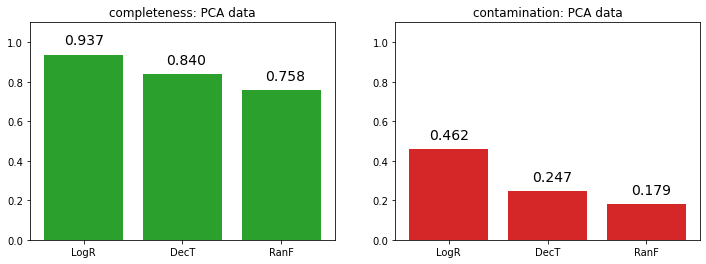

In [18]:
#completeness and contamination for PCA data
fig, ax = plt.subplots(1,2, figsize=(12,4))

alg = ('LogR', 'DecT', 'RanF')
compl = [compl_lr_pca, compl_dt_pca, compl_rf_pca]
cont = [cont_lr_pca, cont_dt_pca, cont_rf_pca]

x_pos = np.arange(len(compl))
ax[0].bar(x_pos,compl, color='tab:green')
ax[1].bar(x_pos, cont, color='tab:red')

ax[0].set_title('completeness: PCA data')
ax[1].set_title('contamination: PCA data')

for i in range(len(ax)):
    ax[i].set_xticks(x_pos)
    ax[i].set_xticklabels(alg)
    ax[i].set_ylim(0, 1.1)

ax[0].text( -0.2, compl[0]+0.05, "%.3f" %compl[0], fontsize=14)
ax[0].text(1-0.16, compl[1]+0.05, "%.3f" %compl[1], fontsize=14)
ax[0].text(2-0.16, compl[2]+0.05, "%.3f" %compl[2], fontsize=14)

ax[1].text( -0.2, cont[0]+0.05, "%.3f" %cont[0], fontsize=14)
ax[1].text(1-0.16, cont[1]+0.05, "%.3f" %cont[1], fontsize=14)
ax[1].text(2-0.16, cont[2]+0.05, "%.3f" %cont[2], fontsize=14)

Completeness is very high with Logistic Regressor, however we also have a lot of false positives here. With Random Forest the accuracy is very high since the contamination is pretty low. In general the contamination is getting worse when the algorithms are applied to PCA data.

### Random Forest Regressor

Here I tried to apply a regressor to the variable 'snr' to then attach labels to test data such that if the predicted snr>12 we have a detection.

Again here we have to establish the optimal number of estimators and here I try a different thing: I fix the number of estimators, knowing that it should be closer to the number chosen before, and evaluate the depth of the tree based on the minimum test error.

In [19]:
#splitting the snr 
x_train, x_test, snr_train, snr_test = train_test_split(feature.T, snr, test_size=0.25, random_state=12)

from sklearn.ensemble import RandomForestRegressor

#selecting the optimal depth
def compute_best_forest(depth):  #depth = a range for depth
    rms_test = np.zeros(len(depth))
    rms_train = np.zeros(len(depth))
    i_best = 0
    z_fit_best = None

    for i, d in enumerate(depth):
        clf = RandomForestRegressor(n_estimators=12, max_depth=d, random_state=0)
        clf.fit(x_train[:,:4], snr_train)

        snr_fit_train = clf.predict(x_train[:,:4])
        snr_fit = clf.predict(x_test[:,:4])
        rms_train[i] = np.mean(np.sqrt((snr_fit_train - snr_train) ** 2)) #rms error for train set 
        rms_test[i] = np.mean(np.sqrt((snr_fit - snr_test) ** 2)) #rms error for test set

        if rms_test[i] <= rms_test[i_best]:  #choosing the best fit as the one that minimize the test error
            i_best = i
            snr_fit_best = snr_fit

    return rms_test, rms_train, i_best, snr_fit_best



In [20]:
#fitting
rms_test, rms_train, i_best, snr_fit_best = compute_best_forest(np.arange(2,25))

The minimum for the rms_test error is reached at a depth of:  16


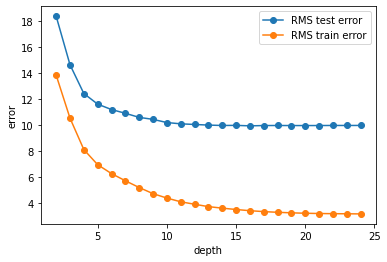

In [21]:
#displaying errors
fig, ax = plt.subplots(1,1, figsize=(6,4))
ax.plot(np.arange(2,25), rms_test, marker='o', label = 'RMS test error')
ax.plot(np.arange(2,25), rms_train, marker='o', label = 'RMS train error')
ax.set_xlabel('depth')
ax.set_ylabel('error')
ax.legend()
print('The minimum for the rms_test error is reached at a depth of: ', np.argmin(rms_test)+2)

In [22]:
#assigning labels and computing completeness, accuracy...
pred_reg = []
for i in range(len(snr_fit_best)):
    if snr_fit_best[i]<12:
        pred_reg.append(0)
    else:
        pred_reg.append(1)
        
acc_rfr = accuracy_score(y_test, pred_reg)
compl_rfr, cont_rfr = completeness_contamination(pred_reg, y_test) #completeness contamination
print('The accuracy is: ', acc_rfr, '\nThe completeness is: ', compl_rfr, '\nThe contamination is: ', cont_rfr)

The accuracy is:  0.9544 
The completeness is:  0.8689458689458689 
The contamination is:  0.18230563002680966


Comparing with the other methods we see that it provides a quite good leel of completeness with a low contamination, but the accuracy is still smaller than the one found through Random Forest, which is the best classifier untill here.

Text(2.75, 0.21230563002680966, '0.182')

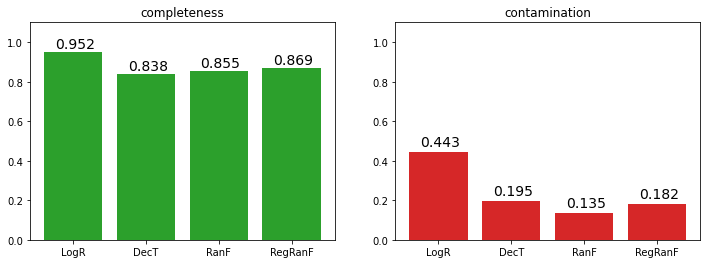

In [23]:
fig, ax = plt.subplots(1,2, figsize=(12,4))

alg = ('LogR', 'DecT', 'RanF', 'RegRanF')
compl = [compl_lr, compl_dt, compl_rf, compl_rfr]
cont = [cont_lr, cont_dt, cont_rf, cont_rfr]

x_pos = np.arange(len(compl))
ax[0].bar(x_pos,compl, color='tab:green')
ax[1].bar(x_pos, cont, color='tab:red')

ax[0].set_title('completeness')
ax[1].set_title('contamination')

for i in range(len(ax)):
    ax[i].set_xticks(x_pos)
    ax[i].set_xticklabels(alg)
    ax[i].set_ylim(0, 1.1)

ax[0].text( -0.25, compl[0]+0.02, "%.3f" %compl[0], fontsize=14)
ax[0].text(1-0.25, compl[1]+0.02, "%.3f" %compl[1], fontsize=14)
ax[0].text(2-0.25, compl[2]+0.02, "%.3f" %compl[2], fontsize=14)
ax[0].text(3-0.25, compl[3]+0.02, "%.3f" %compl[3], fontsize=14)

ax[1].text( -0.25, cont[0]+0.03, "%.3f" %cont[0], fontsize=14)
ax[1].text(1-0.25, cont[1]+0.03, "%.3f" %cont[1], fontsize=14)
ax[1].text(2-0.25, cont[2]+0.03, "%.3f" %cont[2], fontsize=14)
ax[1].text(3-0.25, cont[3]+0.03, "%.3f" %cont[3], fontsize=14)

## Neural Networks

Let's try with neural networks as seen in lecture 22! So here I try first to select through cross validation the optimal number of neurons if we had just 1 layer and the activation function. Then I tried to add more layers manually and I saw that with 2 layers we could reach a slightly higher accuracy. In general I could form different arrays for the 'hidden_layer_sizes' parameter to choose from, but the grid search becomes really expensive, especially if the number of neurons inside each layer is different.

In [24]:
#CAREFUL IT TAKES A LOT
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

scal = StandardScaler()
feature_tr = scal.fit_transform(feature.T)

x_train, x_test, y_train, y_test = train_test_split(feature_tr, det, test_size=0.25, random_state=12)


parameters = {'hidden_layer_sizes':np.arange(10,26), 'activation':['relu', 'tanh', 'logistic']}
grid = GridSearchCV(MLPClassifier(max_iter=500, activation='relu', random_state=0, solver='adam', learning_rate='adaptive',
                                 learning_rate_init=0.001), parameters, n_jobs=-1)

grid.fit(x_train, y_train)
opt_lay = grid.best_params_
print(opt_lay)

{'activation': 'tanh', 'hidden_layer_sizes': 13}


In [25]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

scal = StandardScaler()
feature_tr = scal.fit_transform(feature.T)

x_train, x_test, y_train, y_test = train_test_split(feature_tr, det, test_size=0.25, random_state=12)

mlpc = MLPClassifier(hidden_layer_sizes=(13, 12), activation='tanh', solver='adam', learning_rate='adaptive',
                                                    learning_rate_init=0.001, max_iter=600, random_state=0)
mlpc.fit(x_train, y_train)
y_pred = mlpc.predict(x_test)

y_prob = mlpc.predict_proba(x_test)[:,1] #predicted probability for each test sample to be a quasar
    
fpr_mlpc, tpr_mlpc, thresh_mlpc = roc_curve(y_test, y_prob) #roc curve

compl_mlpc, cont_mlpc = completeness_contamination(y_pred, y_test) #completeness contamination
acc_mlpc = accuracy_score(y_test, y_pred) #accuracy
    
fpr_mlpc = np.concatenate([[0], fpr_mlpc])
tpr_mlpc = np.concatenate([[0], tpr_mlpc])

Text(0.5, 1.0, 'ROC curve')

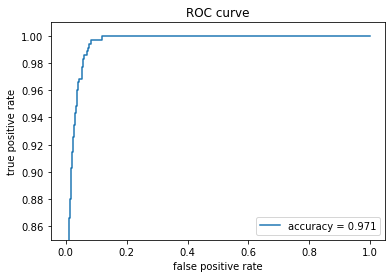

In [26]:
fig, ax = plt.subplots(1,1, figsize=(6,4))
ax.plot(fpr_mlpc, tpr_mlpc, label='accuracy = %.3f' %acc_mlpc)
ax.legend()
ax.set_ylim(0.85, 1.01)
ax.set_xlabel('false positive rate')
ax.set_ylabel('true positive rate')
ax.set_title('ROC curve')

Highest accuracy 'till now! And of course let's compare the results with the methods used before.

Text(3.7, 0.13734463276836156, '0.107')

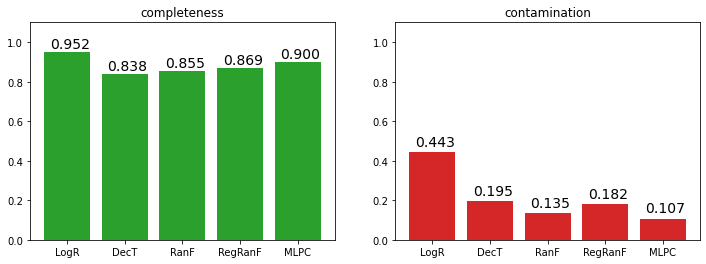

In [27]:
fig, ax = plt.subplots(1,2, figsize=(12,4))

alg = ('LogR', 'DecT', 'RanF', 'RegRanF', 'MLPC')
compl = [compl_lr, compl_dt, compl_rf, compl_rfr, compl_mlpc]
cont = [cont_lr, cont_dt, cont_rf, cont_rfr, cont_mlpc]

x_pos = np.arange(len(compl))
ax[0].bar(x_pos,compl, color='tab:green')
ax[1].bar(x_pos, cont, color='tab:red')

ax[0].set_title('completeness')
ax[1].set_title('contamination')

for i in range(len(ax)):
    ax[i].set_xticks(x_pos)
    ax[i].set_xticklabels(alg)
    ax[i].set_ylim(0, 1.1)

ax[0].text( -0.3, compl[0]+0.02, "%.3f" %compl[0], fontsize=14)
ax[0].text(1-0.3, compl[1]+0.02, "%.3f" %compl[1], fontsize=14)
ax[0].text(2-0.3, compl[2]+0.02, "%.3f" %compl[2], fontsize=14)
ax[0].text(3-0.3, compl[3]+0.02, "%.3f" %compl[3], fontsize=14)
ax[0].text(4-0.3, compl[4]+0.02, "%.3f" %compl[4], fontsize=14)

ax[1].text( -0.3, cont[0]+0.03, "%.3f" %cont[0], fontsize=14)
ax[1].text(1-0.3, cont[1]+0.03, "%.3f" %cont[1], fontsize=14)
ax[1].text(2-0.3, cont[2]+0.03, "%.3f" %cont[2], fontsize=14)
ax[1].text(3-0.3, cont[3]+0.03, "%.3f" %cont[3], fontsize=14)
ax[1].text(4-0.3, cont[4]+0.03, "%.3f" %cont[4], fontsize=14)

MLPC wins over all the other methods! It can reach the lowest contamination!